# Project Requirements
You are to perform analysis of a data set: exploring the statistical summaries of the features, 
visualizing the attributes, and making conclusions from the visualizations and analysis. Follow the 
CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only 
the portions relevant to understanding and visualization). This report is worth 20% of the final 
grade. Please upload a report (one per team) with all code used, visualizations, and text in a single 
document. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in 
whatever format you like, but it is easiest to turn in the rendered iPython notebook. 

# Lab 1
Code for testing and modeling Powershell Obscuration classification using a provided 
data set with predetermined features. PCA may be the preferred method for the unsupervised approach as 
the data provided is not labled. 

WE ARE LOOKING INTO THE DOC_ FEATURES IN THIS FILE

In [47]:
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(style='white')

%matplotlib inline


In [48]:
# Define Global variables
# Define Global

#original_data_path = "../dataset/all.csv" # this file is originally zipped
original_data_path = "../dataset/all_with_labels.csv" # With Labels 

# Some columns are empty for future use. Set to False to not include them
include_unused_columns = False 

# Define unused columns here
unused_columns = ['vt_harmless', 'vt_undetected', 'vt_malicious', 'vt_suspicious',
				  'avclass_name', 'obf_name']

# Remove the string columns sha1 and fpath
include_sha1_fpath = False

# Remove them from the list if set to False 
if include_sha1_fpath == False:
	unused_columns.append('sha1')
	unused_columns.append('fpath')


In [49]:
def create_workable_data(file_path, lst_unused_columns):
	'''import the dataset and format the data into a pandas dataframe.
	+ Read in CSV as dataframe
	+ Remove extra header if there is one 
	+ Remove unused columns if set 
	+ Typecast DataTypes to string and integers
	+ Returns Pandas DataFrame object'''
	try:
		pd_df = pd.read_csv(file_path) # Read in CSV as dataframe
	except FileNotFoundError():
		print("Could not find data file. Make sure the file is unzipped...")
		sys.exit(1)
		
	# Remove Duplicates
	pd_df.drop_duplicates('sha1', inplace=True)
		
	# Check to see if duplicate header is present. Remove if there is 
	if pd_df.at[0, 'sha1'] == 'sha1':
		pd_df = pd_df.iloc[1:] # .iloc[] integer-loc based indexing for selecting by position 
		
	# Remove unused columns if global var "include_unused_columns" is set to False
	if include_unused_columns == False:
		pd_df = pd_df.drop(columns=lst_unused_columns)

	# Convert all to float 
	for col in pd_df.columns.tolist():
		pd_df[col] = pd_df[col].astype(float)
	
	return(pd_df)

In [50]:
def remove_df_rows(data_as_df, char_limit):
    '''Function to remove rows based on the char_limit. char_limit is depicted by
    the doc_char_count feature. 
    @Params:
    - data_as_df (Pandas DataFrame): Data set
    - char_limit (int): Will remove all rows less than or equal to this value
    '''
    working_data = data_as_df # Copy to return
    indx_to_remove = [] # List of index values to remove from DF
    # Find Index's of rows that match the use case 
    for indx in working_data.index.values:
        if float(working_data.at[indx, 'doc_char_count']) <= char_limit:
            indx_to_remove.append(indx)
        else:
            pass

    print('{} row(s) removed that had a document char lenth of {} or less.'.format(
        len(indx_to_remove), char_limit
    ))

    return(working_data.drop(indx_to_remove))

In [51]:
data_df = create_workable_data(original_data_path, unused_columns) # Create a Data Frame from the csv
data_df = remove_df_rows(data_df, 0) # Remove rest of the empty rows 
data_df['is_obf'] = pd.to_numeric(data_df['is_obf'], downcast='integer')
data_df.drop(data_df.loc[data_df['is_obf']==2].index, inplace=True)


1 row(s) removed that had a document char lenth of 0 or less.


# Begin with doc keyword features

In [52]:
data_df_doc_features = data_df.loc[:, 'doc_avg_line_len':]
data_df_doc_features['is_obf'] = data_df.is_obf
data_df_doc_features

,doc_avg_line_len,doc_min_line_len,doc_max_line_len,doc_line_count,doc_mcomment_count,doc_entropy,doc_dtype_bool_word_count,doc_dtype_char_word_count,doc_dtype_int_word_count,doc_dtype_long_word_count,...,doc_keyword_static_word_count,doc_keyword_switch_word_count,doc_keyword_throw_word_count,doc_keyword_trap_word_count,doc_keyword_try_word_count,doc_keyword_until_word_count,doc_keyword_using_word_count,doc_keyword_var_word_count,doc_keyword_while_word_count,is_obf
384192,80.222222,1.0,709.0,27.0,0.0,2.569801,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
384193,67.427572,1.0,393.0,1429.0,0.0,2.478811,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
384194,61020.500000,1.0,122040.0,2.0,0.0,1.977732,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
384195,96.278884,1.0,1922.0,251.0,0.0,2.368537,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
384196,77.096401,1.0,587.0,778.0,0.0,2.624356,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408875,51.998185,1.0,232.0,551.0,0.0,3.357969,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
408876,87.456790,2.0,441.0,81.0,0.0,2.501711,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
408877,42.828996,1.0,318.0,269.0,2.0,3.427758,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
408878,41.986486,0.0,222.0,74.0,0.0,3.674436,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,3


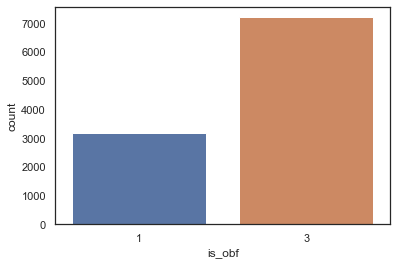

In [53]:
ax = sns.countplot(x="is_obf", data=data_df_doc_features)

In [54]:
data_df_doc_features.describe()

,doc_avg_line_len,doc_min_line_len,doc_max_line_len,doc_line_count,doc_mcomment_count,doc_entropy,doc_dtype_bool_word_count,doc_dtype_char_word_count,doc_dtype_int_word_count,doc_dtype_long_word_count,...,doc_keyword_static_word_count,doc_keyword_switch_word_count,doc_keyword_throw_word_count,doc_keyword_trap_word_count,doc_keyword_try_word_count,doc_keyword_until_word_count,doc_keyword_using_word_count,doc_keyword_var_word_count,doc_keyword_while_word_count,is_obf
count,1.040500e+04,10405.000000,1.040500e+04,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,...,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000,10405.000000
mean,8.866384e+03,1.207785,1.824286e+04,282.826526,1.730802,2.994285,0.029793,0.004037,0.049976,0.013936,...,0.069390,0.208169,0.683325,0.011341,0.495531,0.029313,0.275637,0.170591,0.097453,2.386833
std,7.219357e+04,44.410101,1.473726e+05,1246.047428,14.301771,0.600627,0.521064,0.134364,1.351449,0.249756,...,0.898004,1.531895,4.162842,0.157676,3.816019,0.321601,1.782305,1.156289,0.691102,0.922194
min,0.000000e+00,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.151562e+01,0.000000,1.240000e+02,39.000000,0.000000,2.513273,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,4.200000e+01,1.000000,1.870000e+02,94.000000,0.000000,3.170517,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,7.384265e+01,1.000000,3.710000e+02,219.000000,2.000000,3.407934,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,3.040348e+06,4499.000000,6.080694e+06,49857.000000,846.000000,4.229025,24.000000,8.000000,98.000000,20.000000,...,32.000000,73.000000,303.000000,7.000000,303.000000,12.000000,108.000000,36.000000,28.000000,3.000000


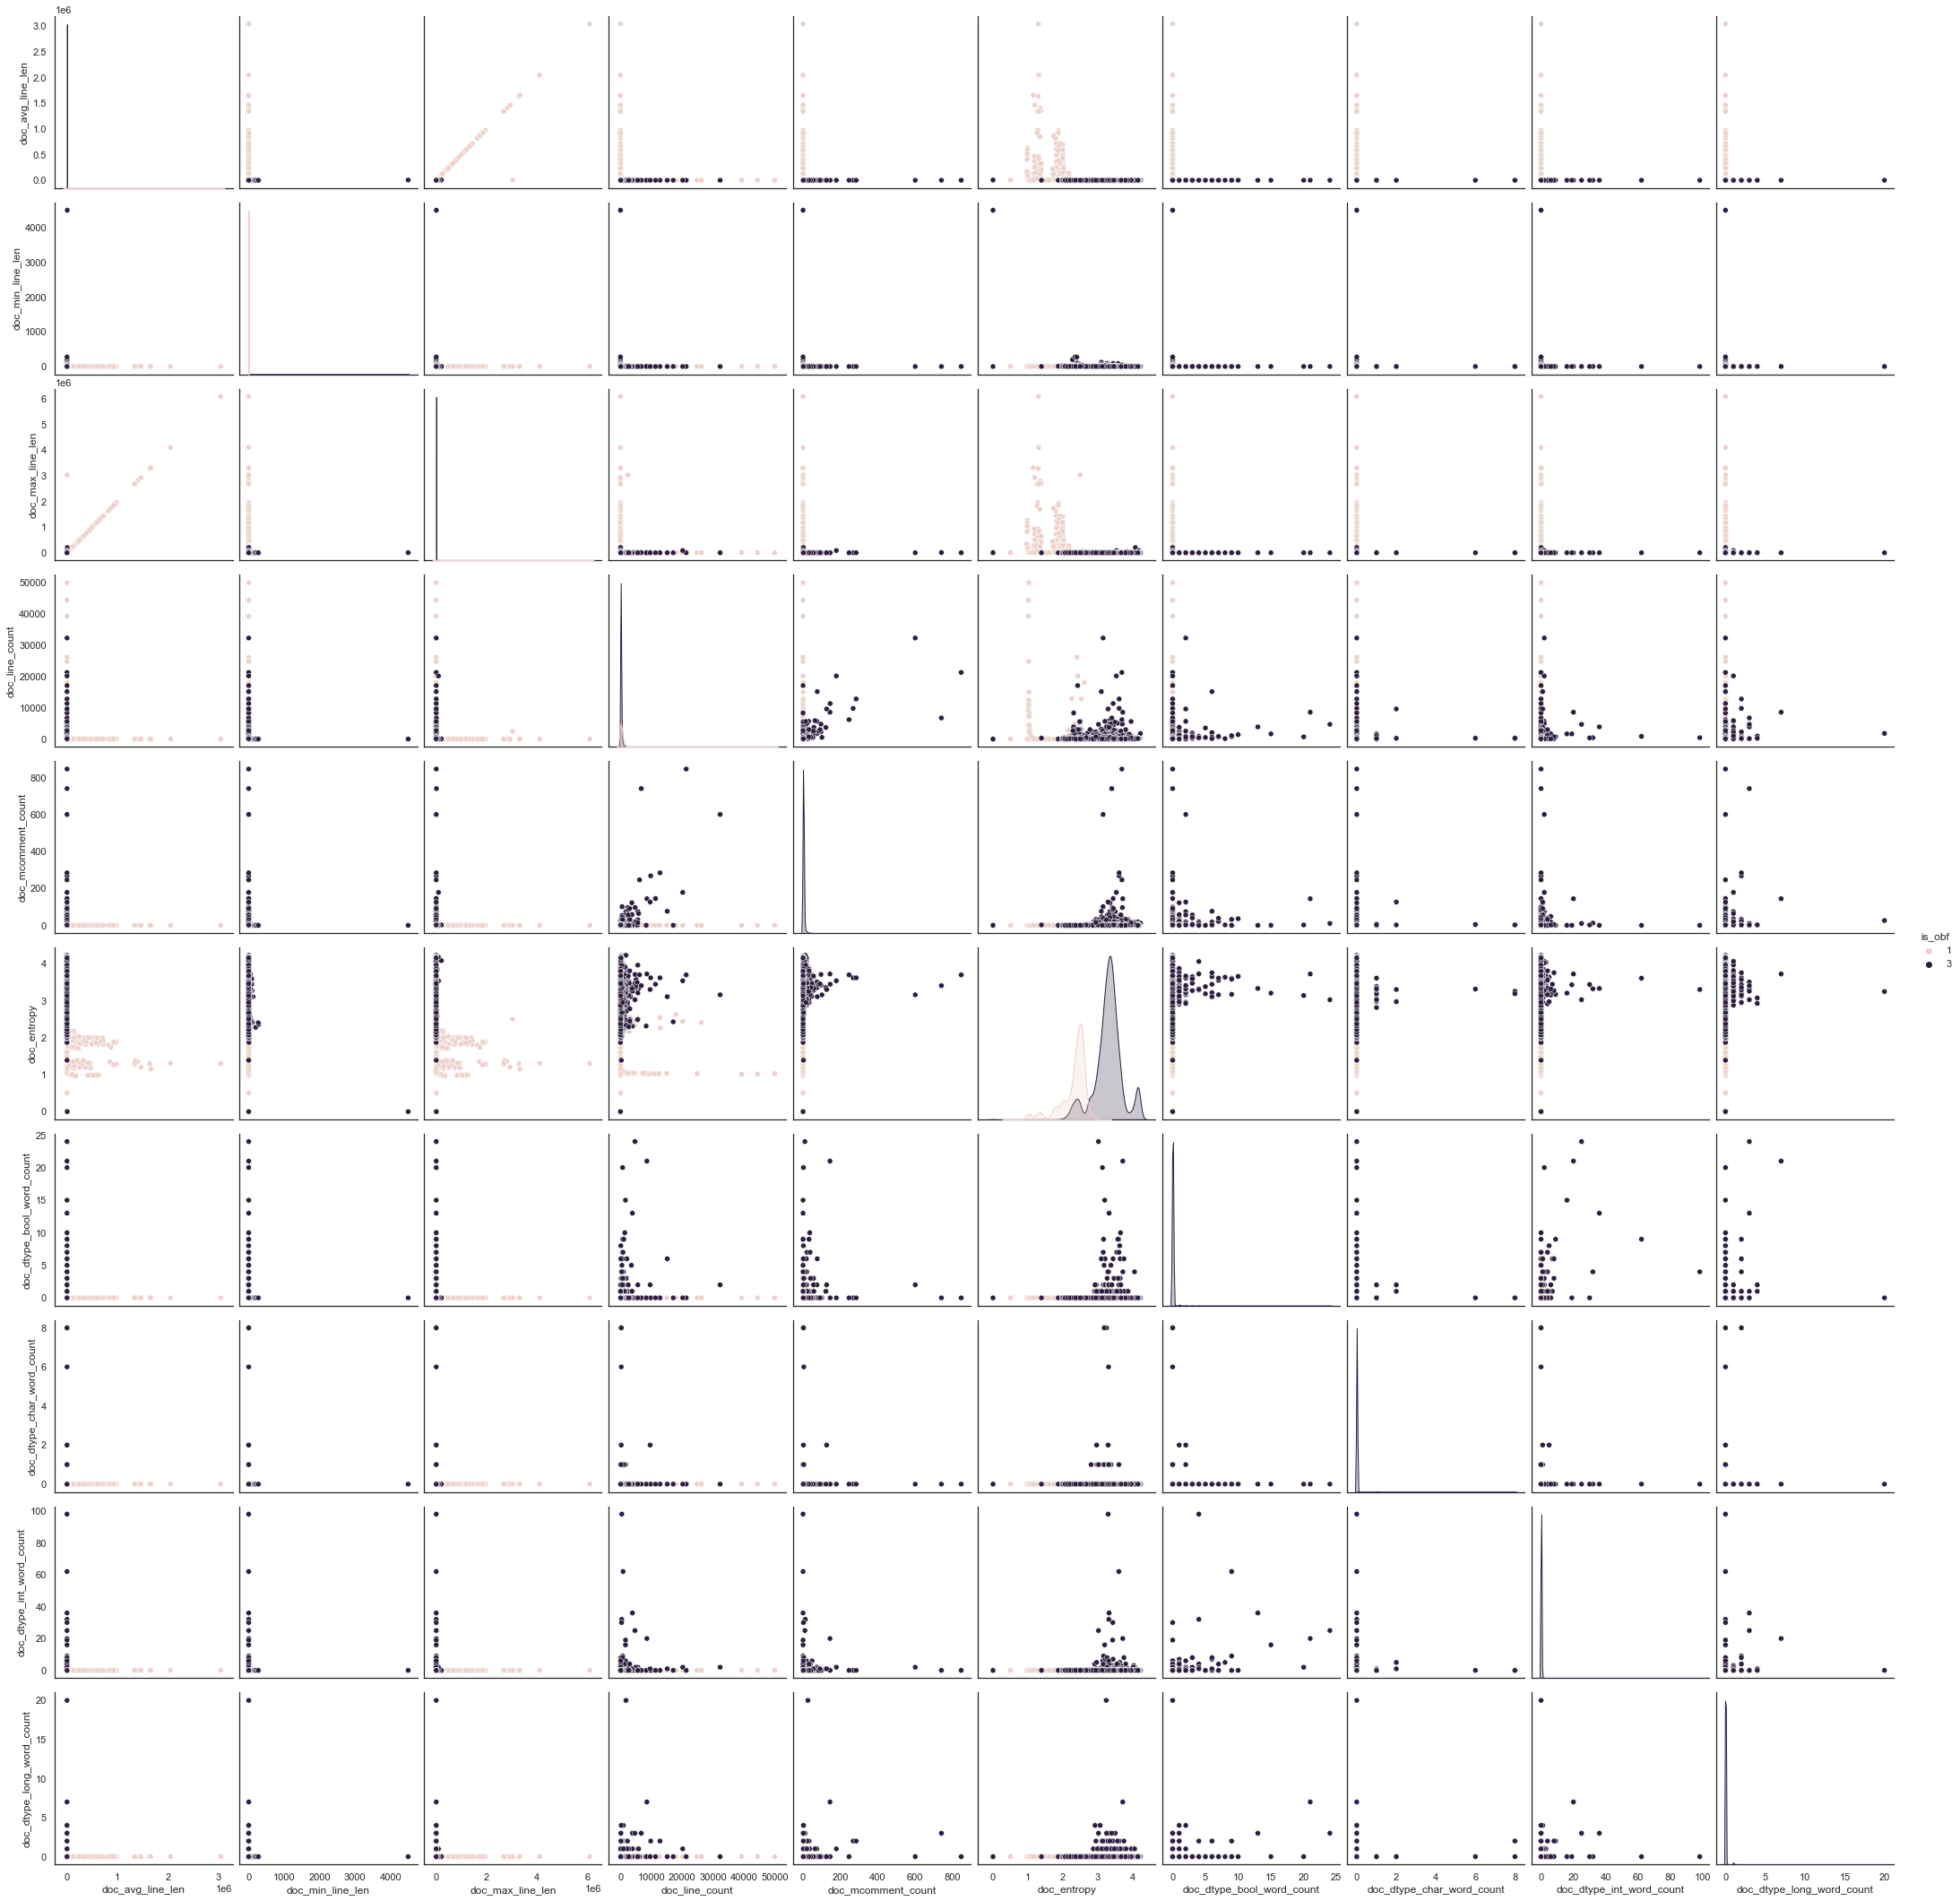

In [55]:
# Pair Plots for features 1:10
sample = data_df_doc_features.loc[:, :'doc_dtype_long_word_count']
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

KeyboardInterrupt: 

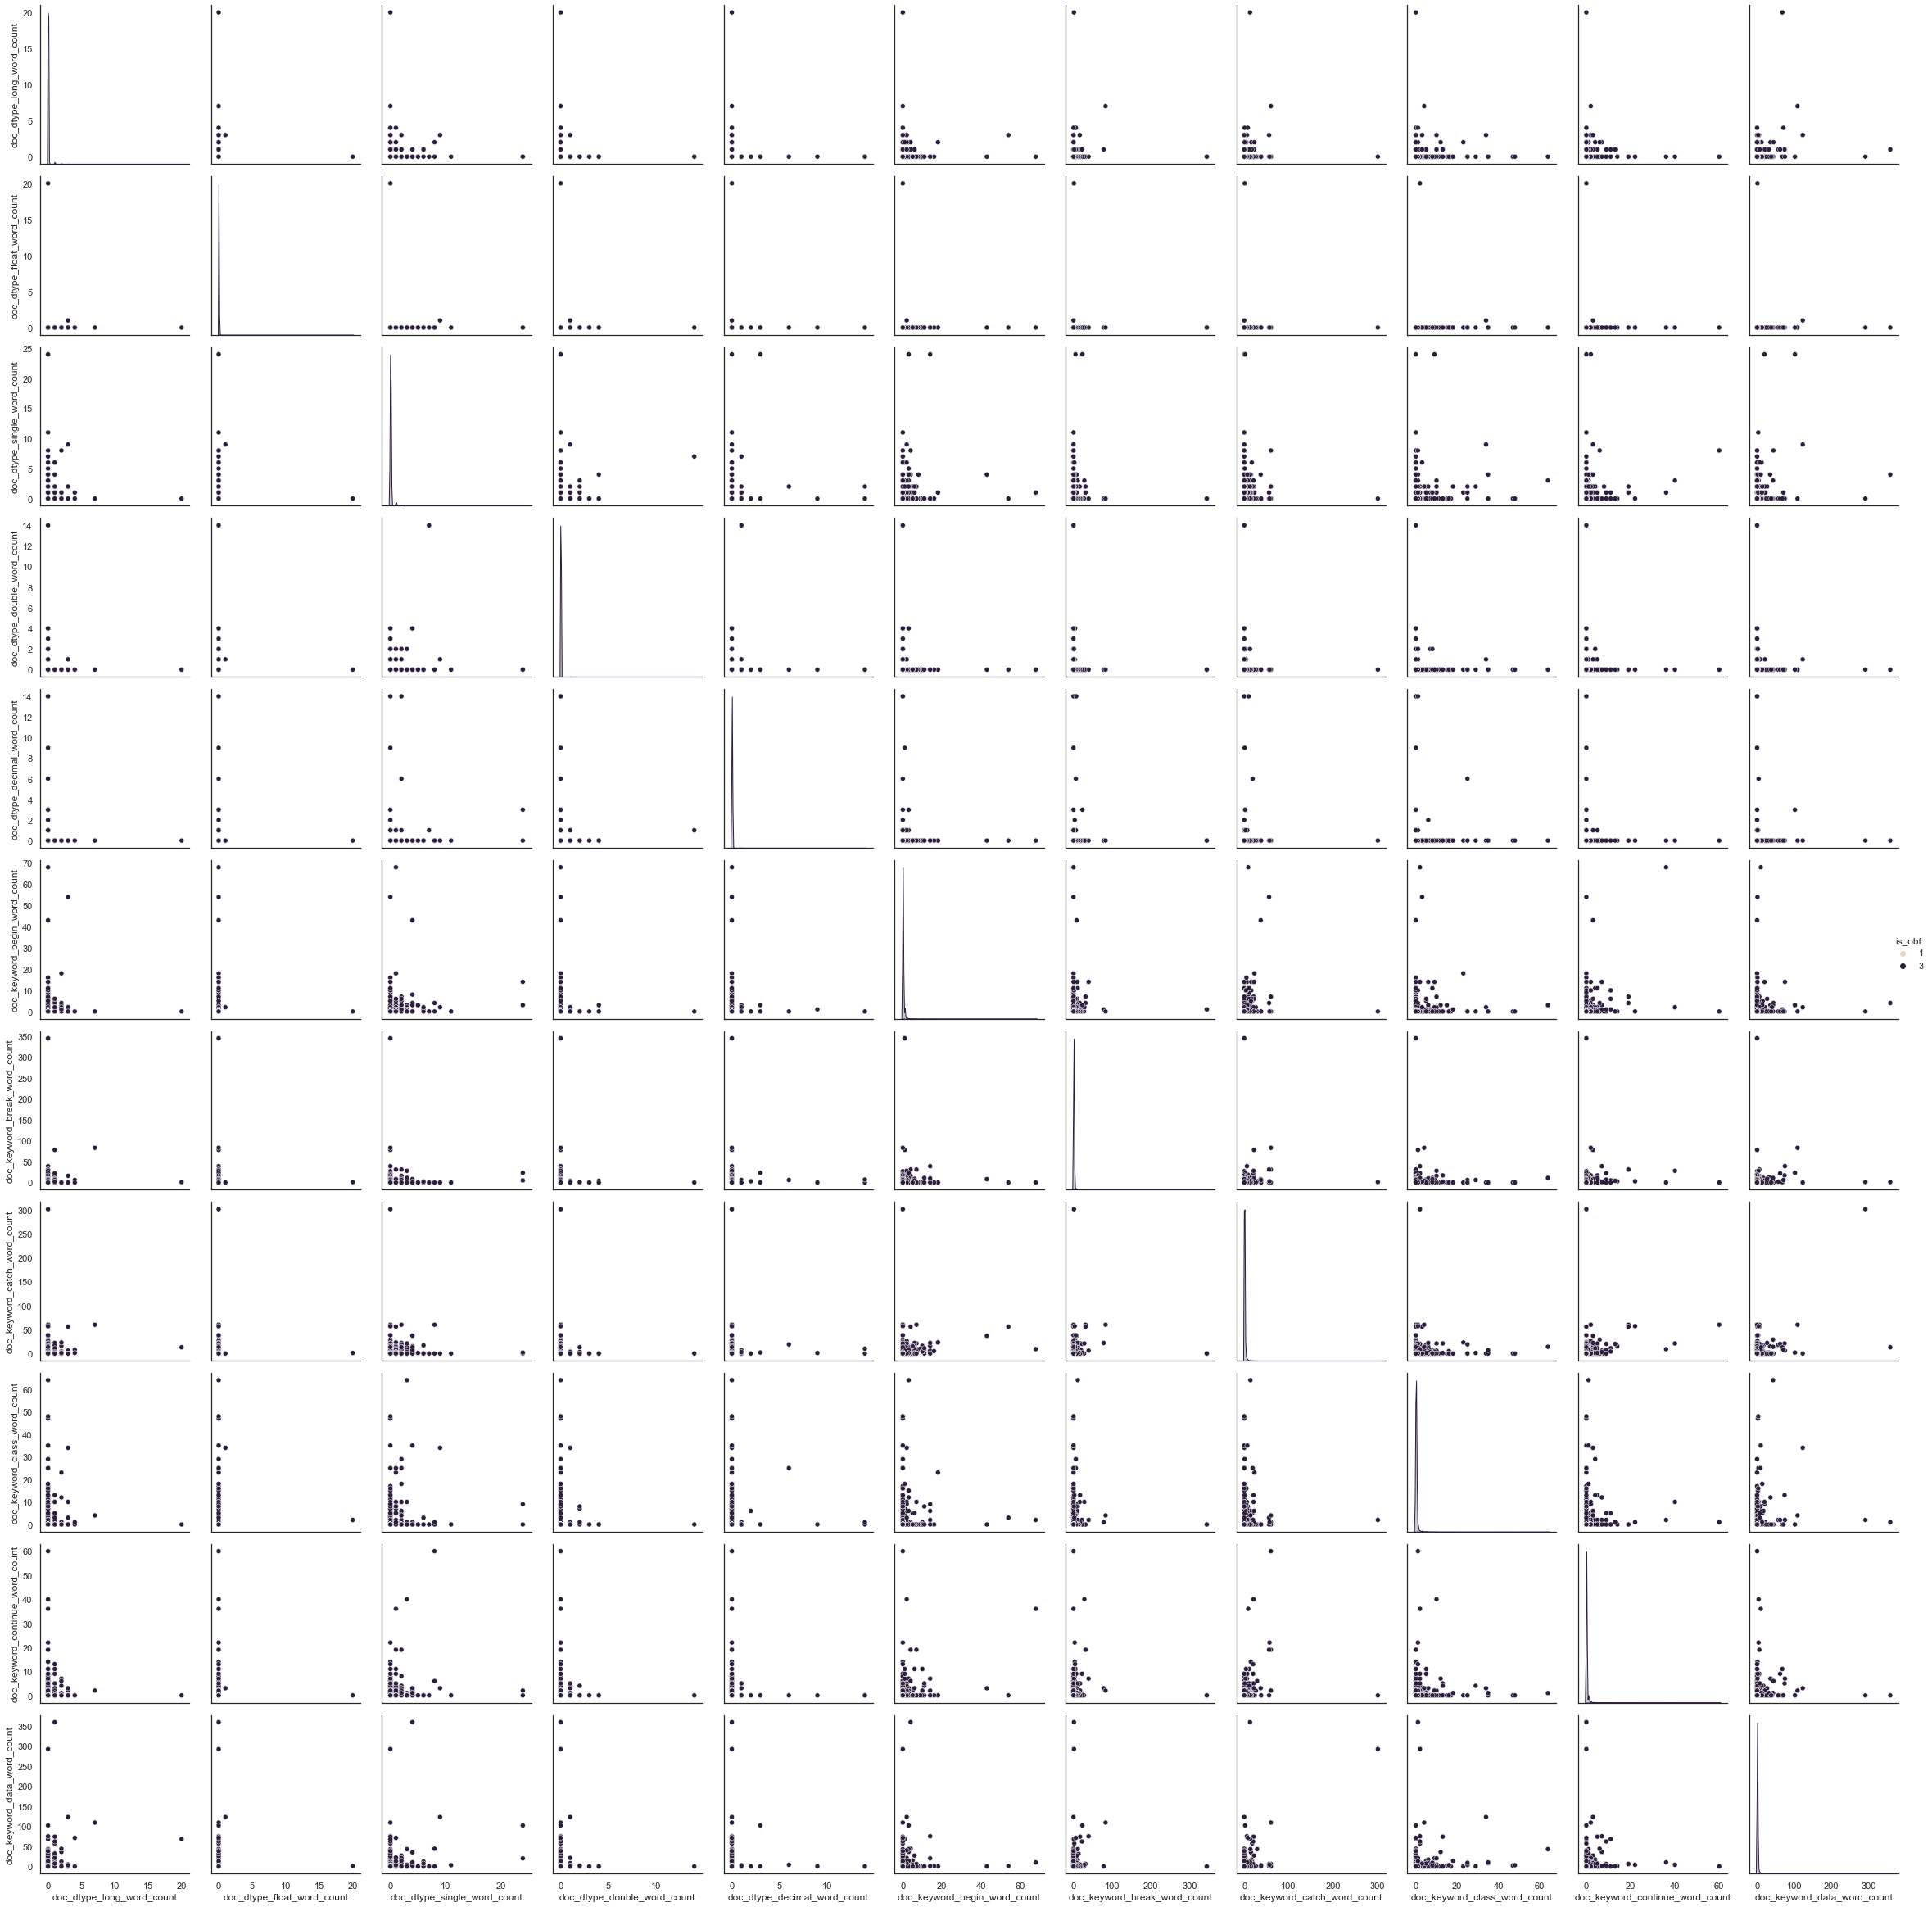

In [56]:
# Pair Plots for features 10:20
sample = data_df_doc_features.loc[:, 'doc_dtype_long_word_count':'doc_keyword_data_word_count']
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

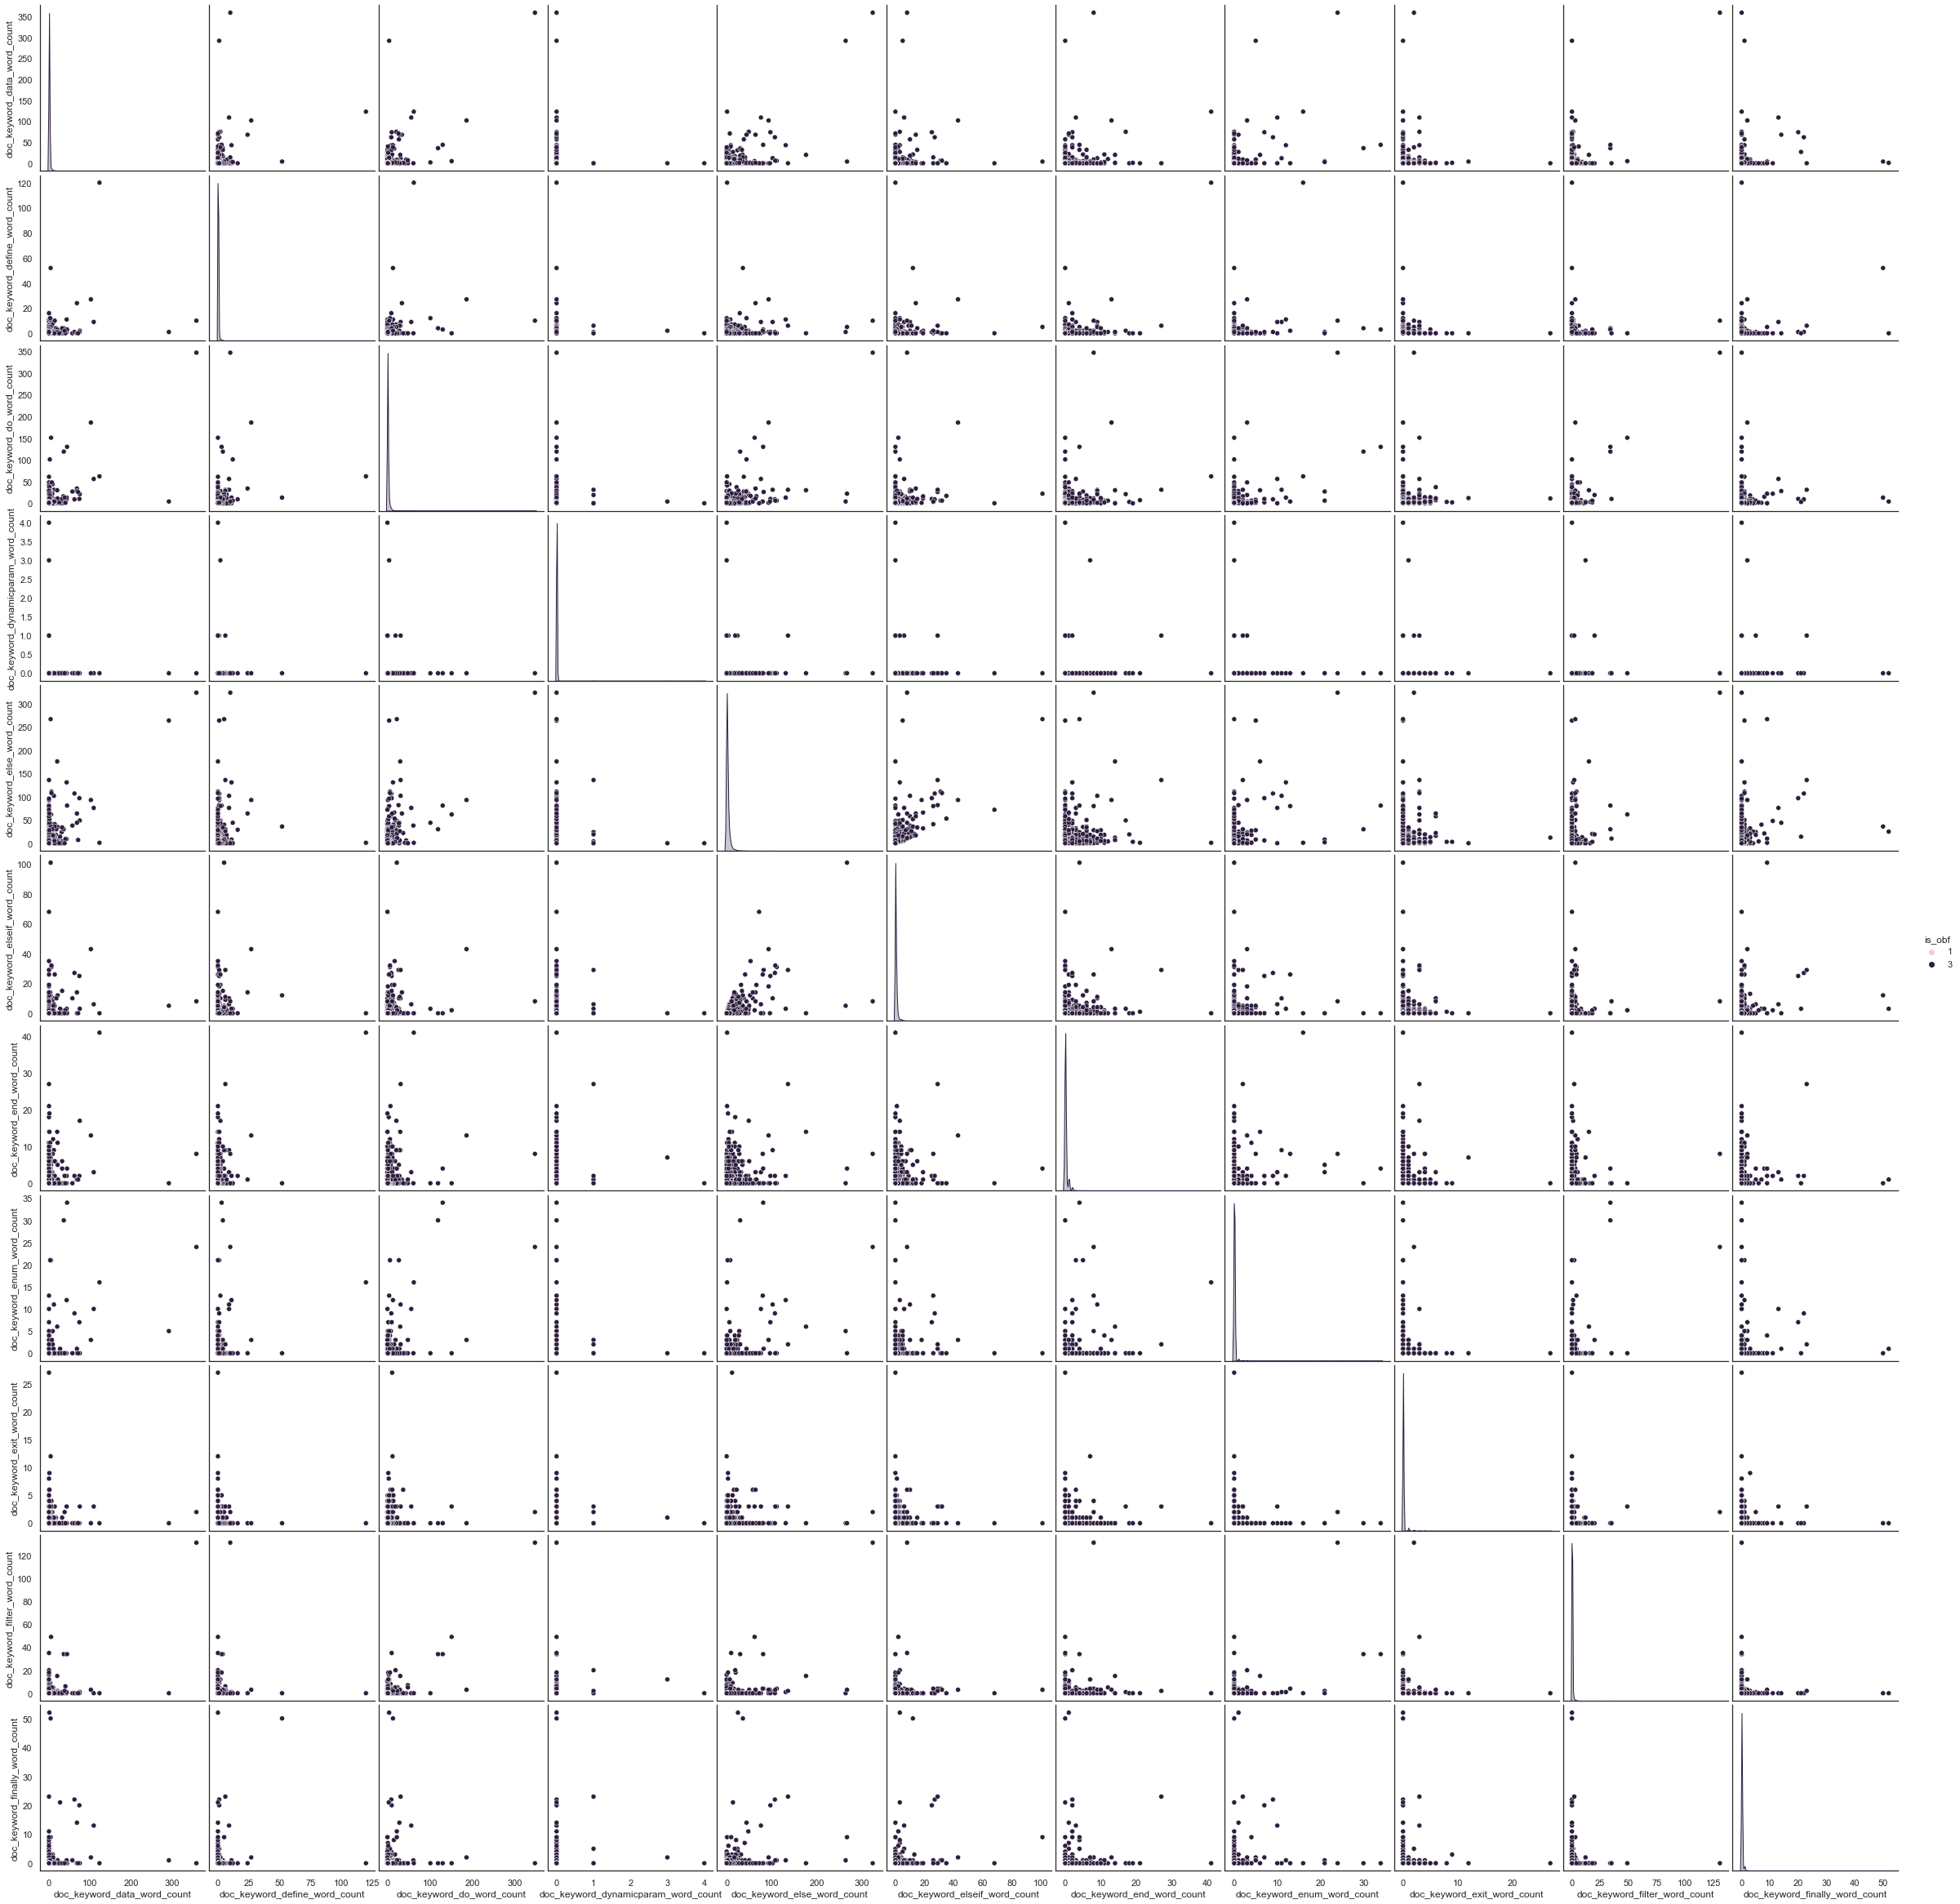

In [ ]:
# Pair Plots for features 20:30
data_df_doc_features.keys()[20:]
sample = data_df_doc_features.loc[:, 'doc_keyword_data_word_count':'doc_keyword_finally_word_count']
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

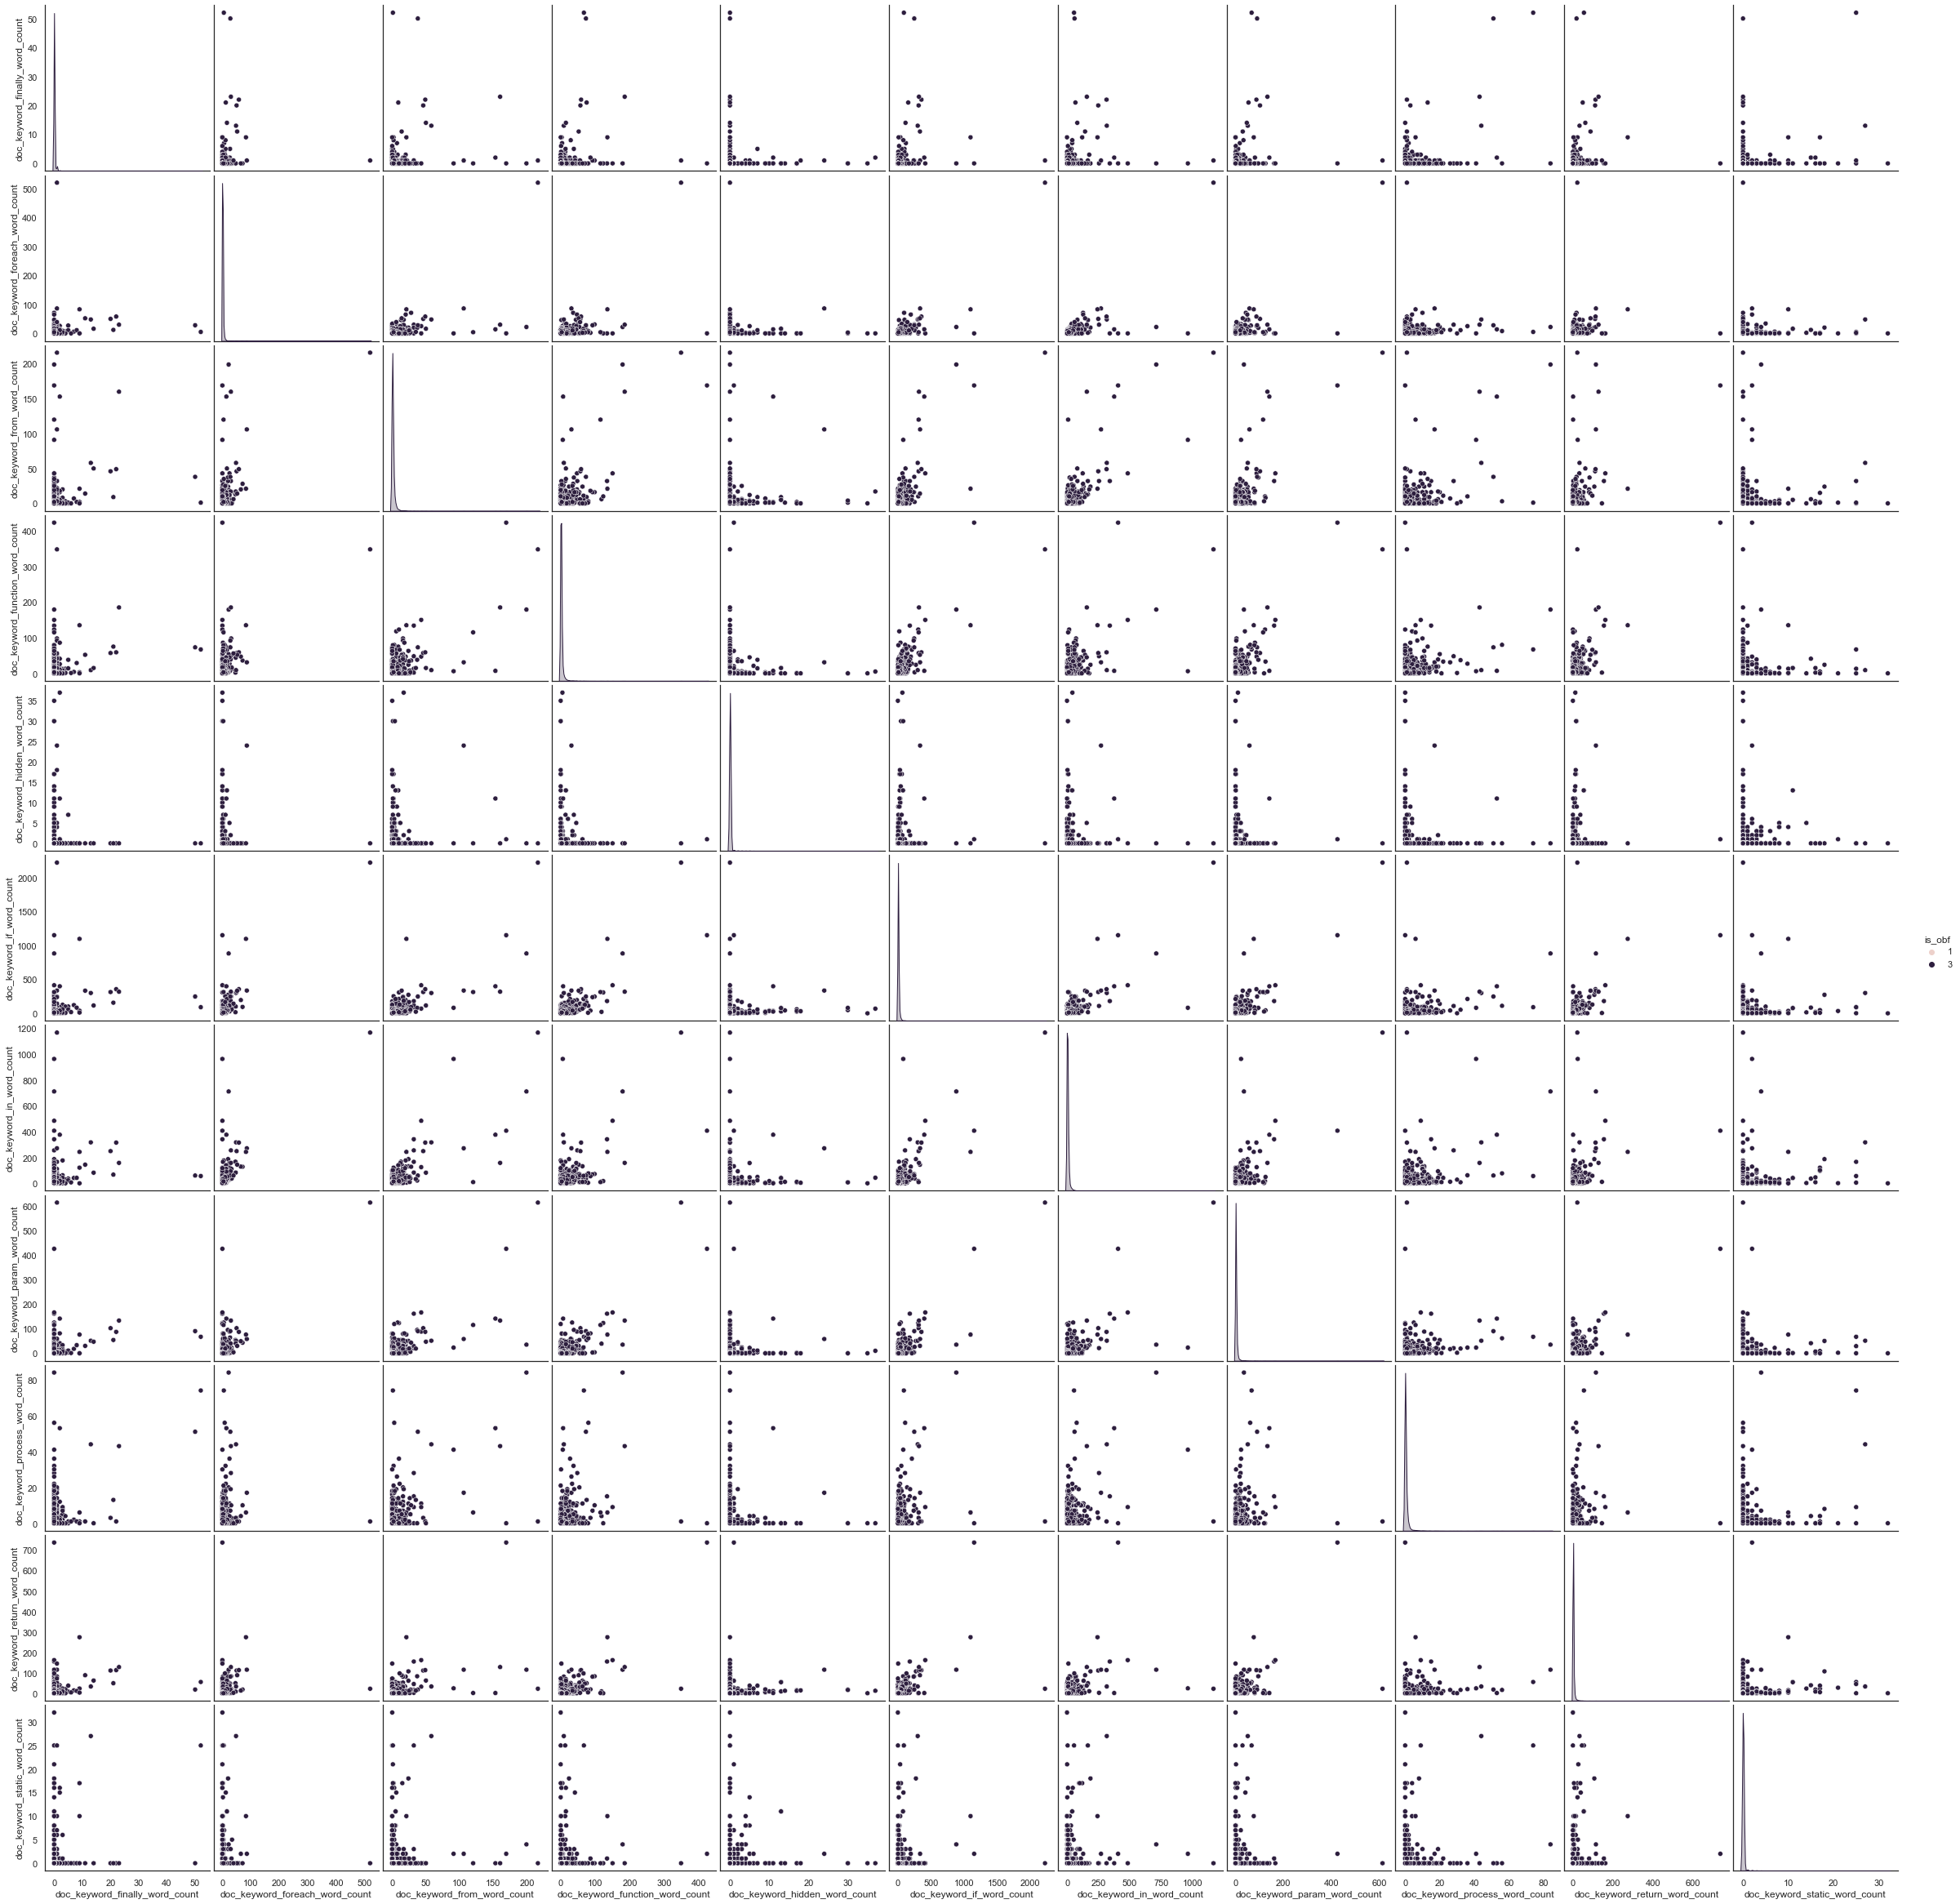

In [ ]:
# Pair Plots for features 30:40
data_df_doc_features.keys()[30:]
sample = data_df_doc_features.loc[:, 'doc_keyword_finally_word_count':'doc_keyword_static_word_count']
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

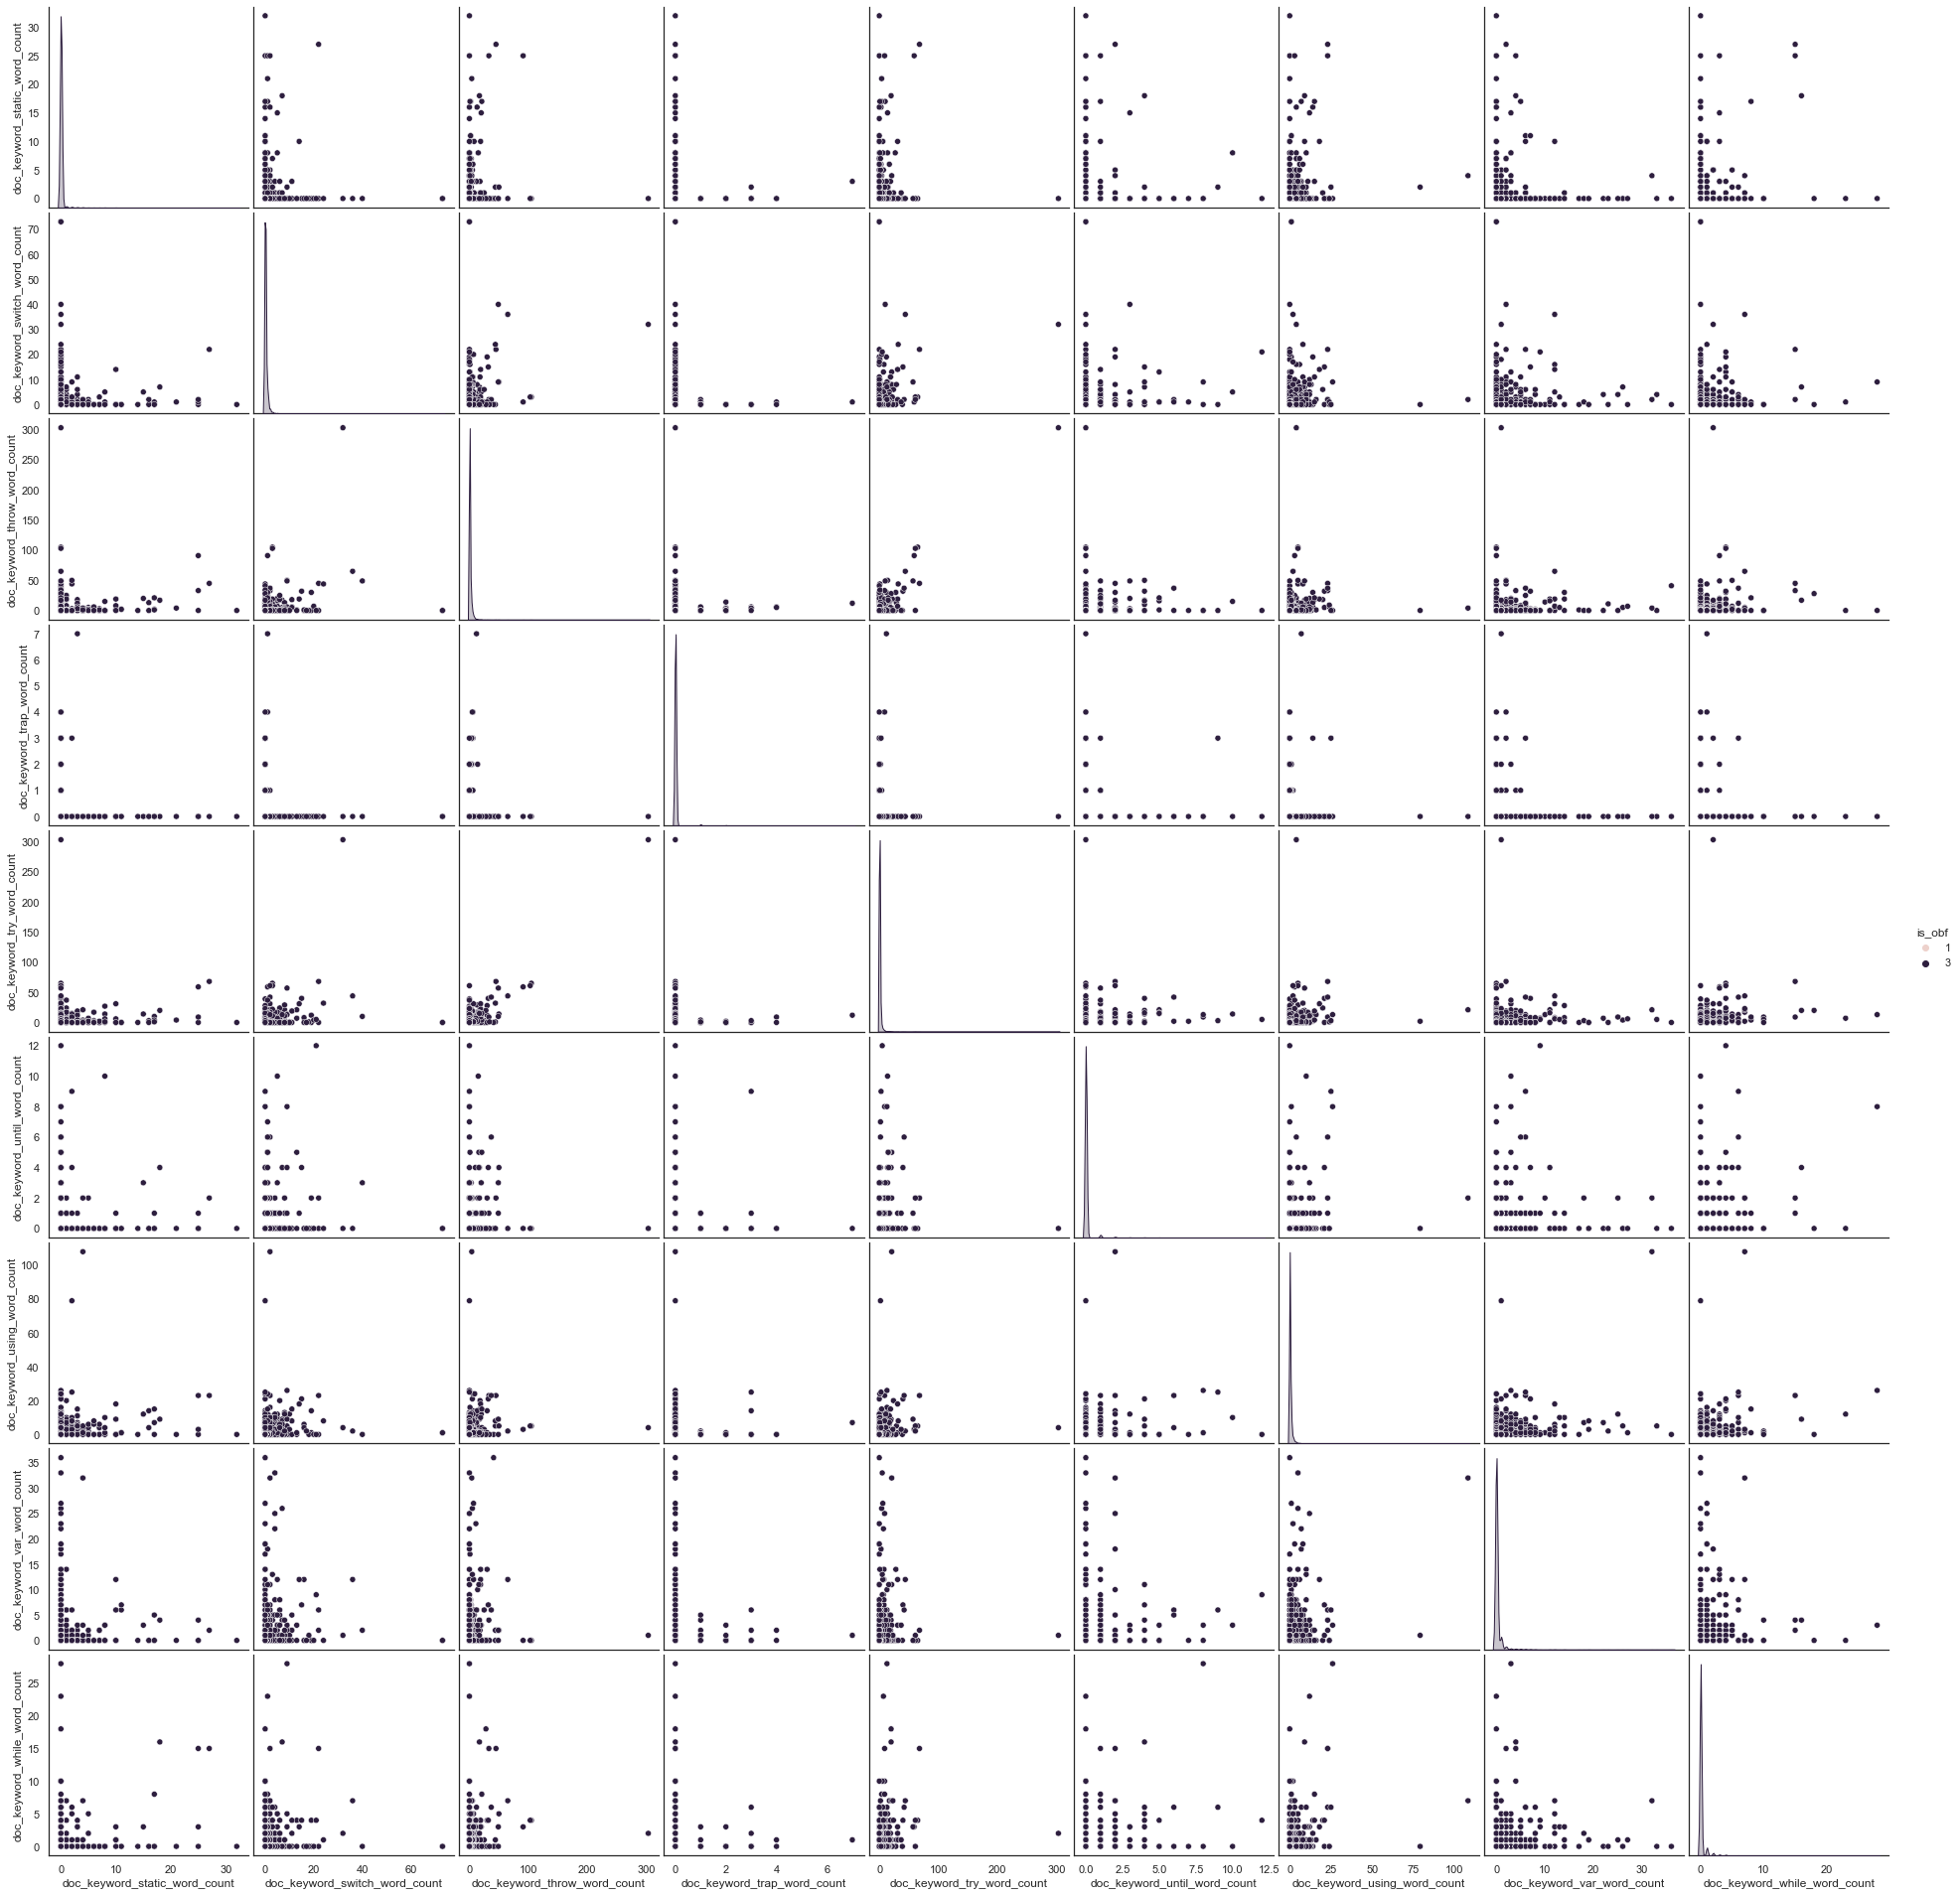

In [ ]:
# Pair Plots for features 40:
data_df_doc_features.keys()[40:]
sample = data_df_doc_features.loc[:, 'doc_keyword_static_word_count':]
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

Interesting, the pair plots don't show any real information for samples with a is_obf value of 1. We dig into this below. 

In [ ]:
# display summary statistics for each feature grouped by obfuscation status. 
data_df_doc_features.keys()
output = data_df_doc_features.groupby('is_obf').describe().T
with pd.option_context('display.max_rows', len(output)):
    display(output)


is_obf                                                1              3
doc_avg_line_len                    count  3.190000e+03    7215.000000
                                    mean   2.882629e+04      41.421627
                                    std    1.281754e+05      87.122382
                                    min    2.500000e+00       0.000000
                                    25%    7.089430e+01      28.693026
                                    50%    8.049818e+01      35.219178
                                    75%    1.927375e+02      44.007109
                                    max    3.040348e+06    5147.878788
doc_min_line_len                    count  3.190000e+03    7215.000000
                                    mean   1.001254e+00       1.299099
                                    std    5.007046e-02      53.332471
                                    min    1.000000e+00       0.000000
                                    25%    1.000000e+00       0.000000
                                    50%    1.000000e+00       0.000000
                                    75%    1.000000e+00       1.000000
                                    max    3.000000e+00    4499.000000
doc_max_line_len                    count  3.190000e+03    7215.000000
                                    mean   5.893656e+04     250.774220
                                    std    2.616245e+05    2988.723982
                                    min    4.000000e+00       0.000000
                                    25%    3.530000e+02     109.000000
                                    50%    5.870000e+02     144.000000
                                    75%    1.679250e+03     201.000000
                                    max    6.080694e+06  202833.000000
doc_line_count                      count  3.190000e+03    7215.000000
                                    mean   4.533881e+02     207.415385
                                    std    1.936842e+03     749.890609
                                    min    2.000000e+00       1.000000
                                    25%    5.000000e+00      48.000000
                                    50%    1.050000e+02      92.000000
                                    75%    4.297500e+02     195.000000
                                    max    4.985700e+04   32223.000000
doc_mcomment_count                  count  3.190000e+03    7215.000000
                                    mean   0.000000e+00       2.496050
                                    std    0.000000e+00      17.119501
                                    min    0.000000e+00       0.000000
                                    25%    0.000000e+00       0.000000
                                    50%    0.000000e+00       2.000000
                                    75%    0.000000e+00       2.000000
                                    max    0.000000e+00     846.000000
doc_entropy                         count  3.190000e+03    7215.000000
                                    mean   2.307210e+00       3.298065
                                    std    3.757672e-01       0.395998
                                    min    4.967465e-01       0.000000
                                    25%    2.217270e+00       3.142316
                                    50%    2.429104e+00       3.328024
                                    75%    2.549205e+00       3.484721
                                    max    3.174324e+00       4.229025
doc_dtype_bool_word_count           count  3.190000e+03    7215.000000
                                    mean   0.000000e+00       0.042966
                                    std    0.000000e+00       0.625301
                                    min    0.000000e+00       0.000000
                                    25%    0.000000e+00       0.000000
                                    50%    0.000000e+00       0.000000
                                    75%    0.000000e+00       0.000000
                        

# wow
So this is super neat. All of the obfuscated samples we have seem to remove the language keywords... Let's see if we can do something about this... 

In [74]:
# create the keyword_test explanatory variable by summing all of the sparse features 
data_df_doc_features['keyword_test']= data_df_doc_features.loc[:, 'doc_entropy':].sum(axis=1)
output = data_df_doc_features.groupby('is_obf').describe().T
# were really only interested in the keyword_test output
output

is_obf                              1             3
doc_avg_line_len count    3190.000000   7215.000000
                 mean    28826.290795     41.421627
                 std    128175.417713     87.122382
                 min         2.500000      0.000000
                 25%        70.894299     28.693026
...                               ...           ...
keyword_test     min        13.470719     27.000000
                 25%        28.955426     90.787992
                 50%        30.861937    163.704691
                 75%        31.942843    315.045803
                 max        37.568915  59734.436832

[392 rows x 2 columns]

<AxesSubplot:xlabel='keyword_test', ylabel='Count'>

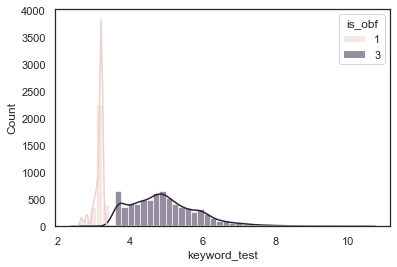

In [71]:
sns.histplot(data=data_df_doc_features, x=np.log(data_df_doc_features.keyword_test), hue="is_obf", kde=True)

<AxesSubplot:xlabel='is_obf', ylabel='keyword_test'>

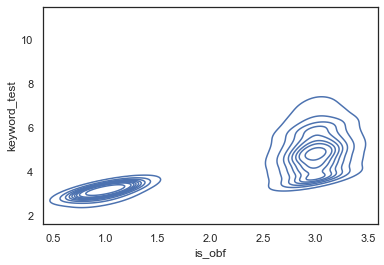

In [72]:
sns.kdeplot(x=data_df_doc_features.is_obf, y=np.log(data_df_doc_features.keyword_test))


<AxesSubplot:xlabel='is_obf', ylabel='keyword_test'>

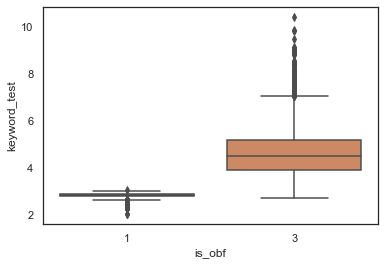

In [68]:
sns.boxplot(x=data_df_doc_features.is_obf, y=np.log(data_df_doc_features.keyword_test))

We get some good separation when we look at the log of the feature sums. Now we do some t-tests. 

In [136]:
# Create a function that will perform a t-test on all the features and return an dictionary of 
# the features along with calculated p-value
def feature_t_tests(dataframe):
    """Takes in pandas df and performs a t-test on all columns that is not
    the target column. The target (is_obf) column what we are testing on.
    Returns Python Dictionary of results."""
    results = dict() # Holds the results and what we are returning

    # Create two data frames that seperate the is_obs
    obs_is_one = dataframe.copy()
    obs_is_one.drop(obs_is_one.loc[obs_is_one['is_obf']==3].index, inplace=True)

    obs_is_three = dataframe.copy()
    obs_is_three.drop(obs_is_three.loc[obs_is_three['is_obf']==1].index, inplace=True)

    # Loop through the list of columns 
    for feat in dataframe.columns.tolist():
        if feat != 'is_obf': # Don't test for the target column
            # perfor a levene test for different variances... sometimes we get insane pvalues so check the test stat too
            l_test_stat, l_p_val = stats.levene(obs_is_one[feat], obs_is_three[feat])

            if (l_p_val < 0.05) and (abs(l_test_stat) > 5):
                # Perform and get test statistic and p-value from Welche's T-Test
                stat, p_val = stats.ttest_ind(obs_is_one[feat], obs_is_three[feat], equal_var=False)
                if abs(stat) > 5 and p_val == 0.0:
                    if stat > 0:
                        p_val = float('inf')
                    else:
                        p_val = float('-inf')
            else: 
                # perform and get test statistic and p-value from standard two sample t-test
                stat, p_val = stats.ttest_ind(obs_is_one[feat], obs_is_three[feat], equal_var=True)
            # Add to dictionary
            results[feat] = (p_val, stat)

    return(results)

data_df_doc_features['keyword_test_log'] = np.log(data_df_doc_features.keyword_test)
p_values_doc_features = feature_t_tests(data_df_doc_features)

# Print Results for Features and p-values sorted by accending
for feat in sorted(p_values_doc_features, key=p_values_doc_features.get, reverse=False):
    print(feat, '\t', '\tp-value:', p_values_doc_features[feat][0], '\ttest statistic:', p_values_doc_features[feat][1]) 

keyword_test_log 	 	p-value: -inf 	test statistic: -160.0868087533051
doc_entropy 	 	p-value: -inf 	test statistic: -121.96753406664708
keyword_test 	 	p-value: 1.8443335076439122e-109 	test statistic: -22.614804831348895
doc_keyword_else_word_count 	 	p-value: 3.3831644039064345e-108 	test statistic: -22.476958750377065
doc_keyword_in_word_count 	 	p-value: 1.898067968487583e-81 	test statistic: -19.360187908201393
doc_keyword_function_word_count 	 	p-value: 3.0543330521766136e-71 	test statistic: -18.04637337193592
doc_keyword_param_word_count 	 	p-value: 5.609627514269434e-67 	test statistic: -17.471141128220793
doc_keyword_end_word_count 	 	p-value: 1.708113636394318e-63 	test statistic: -16.98804573970976
doc_keyword_throw_word_count 	 	p-value: 1.786597670859671e-62 	test statistic: -16.84426665692124
doc_keyword_from_word_count 	 	p-value: 9.333320588562107e-61 	test statistic: -16.59939721941439
doc_keyword_process_word_count 	 	p-value: 1.4147545208878767e-58 	test statistic: 